In [43]:
!pip install shap

In [44]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
import xgboost
import shap

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
df=pd.read_csv('/content/drive/MyDrive/IIITD/Semester 6/BDMH/Project/data.csv')
df=df.dropna()
df=df[df.cough != 'None']
df=df[df.fever != 'None']
df=df[df.sore_throat != 'None']
df=df[df.age_60_and_above != 'None']
df=df[df.gender != 'None']
df=df[df.corona_result != 'other']
print(df.head())
print(df.shape)

Columns (2,3,4,5,6,8) have mixed types.Specify dtype option on import or set low_memory=False.


        Unnamed: 0   test_date cough  ... age_60_and_above  gender test_indication
122808      122808  2020-04-14     1  ...              Yes    male           Other
122809      122809  2020-04-14     1  ...               No  female           Other
122810      122810  2020-04-14     0  ...               No  female           Other
122811      122811  2020-04-14     0  ...               No  female          Abroad
122812      122812  2020-04-14     1  ...              Yes  female           Other

[5 rows x 11 columns]
(2288192, 11)


In [62]:
x=df[['cough','fever','sore_throat','shortness_of_breath','head_ache','age_60_and_above','gender','test_indication']]
y=df[['corona_result']]
x=x.to_numpy(dtype=str)
#### Changing x
tmp=x[:,5]
tmp[tmp=='No']=0
tmp[tmp=='Yes']=1
tmp=x[:,6]
tmp[tmp=='female']=0
tmp[tmp=='male']=1
tmp=x[:,7]
tmp[tmp=='Abroad']=0
tmp[tmp=='Contact with confirmed']=1
tmp[tmp=='Other']=2
x=x.astype(int)
##### Changing y
y=y.to_numpy()
y=y.reshape((y.shape[0],))
y[y=='negative']=0
y[y=='positive']=1
y=y.astype(int)
print(x.shape,y.shape)

(2288192, 8) (2288192,)


In [74]:
##### EDA


[0 1] [2176128  112064]


In [66]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,stratify=y,random_state=22)

In [68]:
# Decision Tree
model = DecisionTreeClassifier(random_state=30)
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
print(model.score(x_test,y_test))

0.9307284640866593


In [67]:
# GNB 
model_gnb = GaussianNB()
model_gnb.fit(x_train,y_train)
y_pred=model_gnb.predict(x_test)
model_gnb.score(x_test,y_test)

0.9052163424419265

In [69]:
# gradient boosting classifier
model_gb = GradientBoostingClassifier(max_depth=4,random_state=30)
model_gb.fit(x_train,y_train)
y_pred=model_gb.predict(x_test)
model_gb.score(x_test,y_test)

0.9306599966786023

Decision tree: ROC AUC=0.822
GNB: ROC AUC=0.811
Gradient Boosting: ROC AUC=0.822


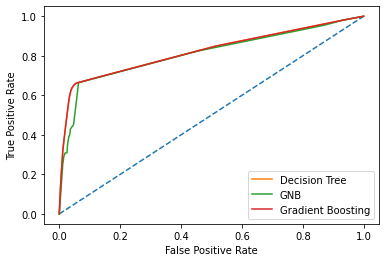

In [52]:
#### ROC curve and area under ROC

ns_probs = [0 for i in range(len(y_test))]

dt_probs = model.predict_proba(x_test)
dt_probs = dt_probs[:, 1]
gnb_probs=model_gnb.predict_proba(x_test)
gnb_probs=gnb_probs[:,1]
gb_probs=model_gb.predict_proba(x_test)
gb_probs=gb_probs[:,1]


# calculate score
dt_auc = roc_auc_score(y_test, dt_probs)
gnb_auc = roc_auc_score(y_test, gnb_probs)
gb_auc = roc_auc_score(y_test, gb_probs)

# summarize scores
print('Decision tree: ROC AUC=%.3f' % (dt_auc))
print('GNB: ROC AUC=%.3f' % (gnb_auc))
print('Gradient Boosting: ROC AUC=%.3f' % (gb_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)
gnb_fpr, gnb_tpr, _ = roc_curve(y_test, gnb_probs)
gb_fpr, gb_tpr, _ = roc_curve(y_test, gb_probs)

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--')
pyplot.plot(dt_fpr, dt_tpr, label='Decision Tree')
pyplot.plot(gnb_fpr, gnb_tpr, label='GNB')
pyplot.plot(gb_fpr, gb_tpr, label='Gradient Boosting')

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

Decision Tree: f1=0.618 auc=0.557
GNB: f1=0.478 auc=0.520
Gradient Boosting: f1=0.623 auc=0.557


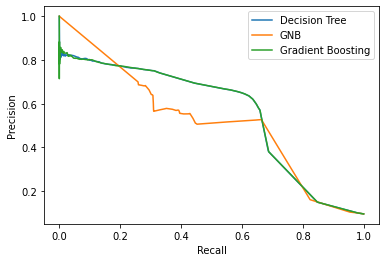

In [53]:
##### au Precision Recall curves & f1-score

# predict probabilities
dt_probs = model.predict_proba(x_test)
dt_probs = dt_probs[:, 1]
gnb_probs = model_gnb.predict_proba(x_test)
gnb_probs = gnb_probs[:, 1]
gb_probs = model_gb.predict_proba(x_test)
gb_probs = gb_probs[:, 1]

# predict class values
yhat_dt = model.predict(x_test)
dt_precision, dt_recall, _ = precision_recall_curve(y_test, dt_probs)
dt_f1 = f1_score(y_test, yhat_dt)
dt_auc = auc(dt_recall, dt_precision)

yhat_gnb = model_gnb.predict(x_test)
gnb_precision, gnb_recall, _ = precision_recall_curve(y_test, gnb_probs)
gnb_f1 = f1_score(y_test, yhat_gnb)
gnb_auc = auc(gnb_recall, gnb_precision)

yhat_gb = model_gb.predict(x_test)
gb_precision, gb_recall, _ = precision_recall_curve(y_test, gb_probs)
gb_f1 = f1_score(y_test, yhat_gb)
gb_auc = auc(gb_recall, gb_precision)

# summarize scores
print('Decision Tree: f1=%.3f auc=%.3f' % (dt_f1, dt_auc))
print('GNB: f1=%.3f auc=%.3f' % (gnb_f1, gnb_auc))
print('Gradient Boosting: f1=%.3f auc=%.3f' % (gb_f1, gb_auc))

# plot the precision-recall curves
pyplot.plot(dt_recall, dt_precision, label='Decision Tree')
pyplot.plot(gnb_recall, gnb_precision, label='GNB')
pyplot.plot(gb_recall, gb_precision, label='Gradient Boosting')

pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

In [ ]:
feature_names = ['Cough','Fever','Sore Throat','Shortness_of_breath','Headache','Age_60_and_above','Gender','Contact with covid patient']
x_df = pd.DataFrame(x_train, columns=feature_names)
# train XGBoost model
model = xgboost.XGBClassifier().fit(x_df, np.ravel(y_train))
# compute SHAP values
explainer = shap.Explainer(model, x_df)
shap_values = explainer(x_df)
shap.plots.beeswarm(shap_values)

 17%|===                 | 266707/1601734 [02:56<14:40]       